In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.regressor import AlphaSelection
from scipy.stats import kde
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier

In [3]:
combat = pd.read_csv('combats.csv')

In [4]:
pokemon = pd.read_csv('pokemon.csv')

In [5]:
combat.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [6]:
pokemon.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In this part, you will explore the data to address the curiosities of the demanding Professor Oak.

(6 points) Explore the data and report some descriptive statistics (e.g., use df.describe(), report the number of classes, summarize the attack and defense distributions, etc.). This will be useful later in your analysis.

In [7]:
pokemon.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [8]:
np.sort(pokemon['HP'].unique())

array([  1,  10,  20,  25,  28,  30,  31,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  88,  89,  90,  91,  92,  95,  97,
        99, 100, 101, 103, 104, 105, 106, 108, 109, 110, 111, 114, 115,
       116, 120, 123, 125, 126, 130, 135, 140, 144, 150, 160, 165, 170,
       190, 250, 255], dtype=int64)

In [9]:
print(pokemon.groupby(by = 'HP').size().to_string)

<bound method Series.to_string of HP
1      1
10     1
20     6
25     2
28     1
      ..
165    1
170    1
190    1
250    1
255    1
Length: 94, dtype: int64>


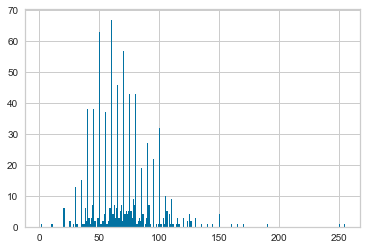

In [10]:
# multiples of 5 are more common!
pokemon['HP'].hist(bins=254)

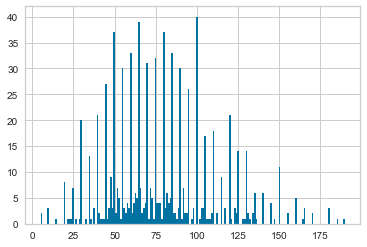

In [11]:
# multiples of 5 are more common!
pokemon['Attack'].hist(bins=184)

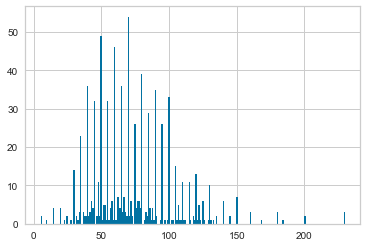

In [12]:
# multiples of 5 are more common!
pokemon['Defense'].hist(bins=224)

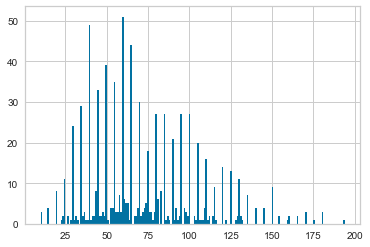

In [13]:
# multiples of 5 are more common!
pokemon['Sp. Atk'].hist(bins=183)

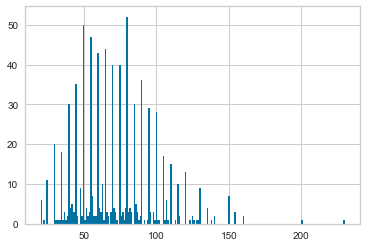

In [14]:
# multiples of 5 are more common!
pokemon['Sp. Def'].hist(bins=209)

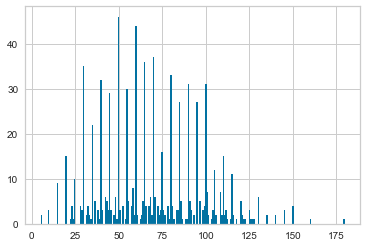

In [15]:
# multiples of 5 are more common!
pokemon['Speed'].hist(bins=209)

In [16]:
a = pokemon['Class 1'].unique()
a.sort()
print(a)

['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']


In [17]:
b = pokemon['Class 2'].unique()
b = [x for x in b if str(x) != 'nan']
b.sort()
print(b)

['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


We see that both categories have the same pokemon types. Only class 2 has some nan values since some pokemon are only of one type.

(4 points) Compare the probability distribution of the “regular attack” feature with that of the “regular defense” feature. In particular,
visualize the relation between these two variables using an appropriate plot;
* list the names of the 3 Pokémon with highest attack-over-defense ratio;
* list the names of the 3 Pokémon with lowest attack-over-defense ratio;
* list the names of the 10 Pokémon with the largest number of victori

In [18]:
def heat_map(x, y, sx, sy):
    x = x[y.notnull()]
    y = y[y.notnull()]
    merge = np.array([x,y])
    # Create a figure with 6 plot areas
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))

    # Everything sarts with a Scatterplot
    axes[0].set_title('Scatterplot')
    axes[0].plot(x, y, 'ko')
    axes[0].set_xlabel(sx)
    axes[0].set_ylabel(sy)
    # As you can see there is a lot of overplottin here!
    
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins = 100
    k = kde.gaussian_kde(merge)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    # Heatmap, contours can also be enabled below
    axes[1].set_title('Heat map')
    axes[1].set_xlabel(sx)
    axes[1].set_ylabel(sy)
    axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    #axes[1].contour(xi, yi, zi.reshape(xi.shape) )

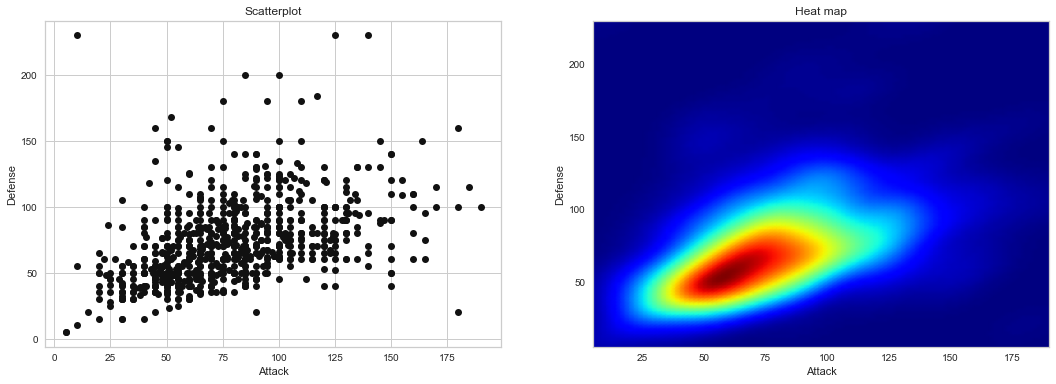

In [19]:
heat_map(pokemon["Attack"], pokemon["Defense"], "Attack", "Defense")

In [20]:
pokemon.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [21]:
pokemon['A_D_ratio'] = pokemon['Attack'] / pokemon['Defense']
pokemon.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,A_D_ratio
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False,1.000000
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False,0.984127
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False,0.987952
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False,0.813008
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False,1.209302


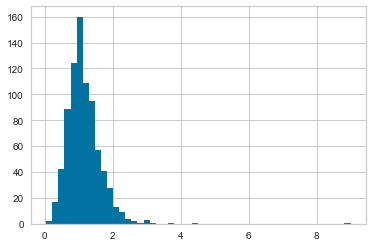

In [22]:
pokemon['A_D_ratio'].hist(bins=50)

In [23]:
pokemon['A_D_ratio'].sort_values()

230    0.043478
139    0.181818
484    0.279070
103    0.281250
616    0.285714
         ...   
428    3.000000
453    3.125000
19     3.750000
347    4.500000
429    9.000000
Name: A_D_ratio, Length: 800, dtype: float64

In [24]:
#highest A/D ratio
print(pokemon.iloc[429])
print(pokemon.iloc[347])
print(pokemon.iloc[19])

pid                         430
Name         DeoxysAttack Forme
Class 1                 Psychic
Class 2                     NaN
HP                           50
Attack                      180
Defense                      20
Sp. Atk                     180
Sp. Def                      20
Speed                       150
Legendary                  True
A_D_ratio                     9
Name: 429, dtype: object
pid               348
Name         Carvanha
Class 1         Water
Class 2          Dark
HP                 45
Attack             90
Defense            20
Sp. Atk            65
Sp. Def            20
Speed              65
Legendary       False
A_D_ratio         4.5
Name: 347, dtype: object
pid                     20
Name         Mega Beedrill
Class 1                Bug
Class 2             Poison
HP                      65
Attack                 150
Defense                 40
Sp. Atk                 15
Sp. Def                 80
Speed                  145
Legendary            False
A_D_r

A: DeoxysAttack Forme, Carvanha, Mega Beedrill

In [25]:
#highest A/D ratio
print(pokemon.iloc[230])
print(pokemon.iloc[139])
print(pokemon.iloc[484])

pid                231
Name           Shuckle
Class 1            Bug
Class 2           Rock
HP                  20
Attack              10
Defense            230
Sp. Atk             10
Sp. Def            230
Speed                5
Legendary        False
A_D_ratio    0.0434783
Name: 230, dtype: object
pid               140
Name         Magikarp
Class 1         Water
Class 2           NaN
HP                 20
Attack             10
Defense            55
Sp. Atk            15
Sp. Def            20
Speed              80
Legendary       False
A_D_ratio    0.181818
Name: 139, dtype: object
pid              485
Name         Bronzor
Class 1        Steel
Class 2      Psychic
HP                57
Attack            24
Defense           86
Sp. Atk           24
Sp. Def           86
Speed             23
Legendary      False
A_D_ratio    0.27907
Name: 484, dtype: object


Shuckle, Magikarp, Bronzor

In [26]:
# what pokemon won the most? NOTE: this is not winrate, just the amount of wins

In [27]:
combat['Winner'].value_counts()

163    152
154    136
438    136
428    134
432    133
      ... 
189      5
237      4
639      4
190      3
290      3
Name: Winner, Length: 783, dtype: int64

In [28]:
pd.DataFrame(combat['Winner'].value_counts()[0:10]).index

Int64Index([163, 154, 438, 428, 432, 314, 214, 394, 249, 155], dtype='int64')

In [29]:
winners = np.array(pd.DataFrame(combat['Winner'].value_counts()[0:10]).index)

In [30]:
pokemon['Name'].iloc[winners]

163          Mega Mewtwo X
154        Mega Aerodactyl
438                 Piplup
428    Deoxys Normal Forme
432                Turtwig
314                Nincada
214               Slowking
394                 Wynaut
249                Kingdra
155                Snorlax
Name: Name, dtype: object

(10 points) Professor Oak suspects that Pokémon in the grass class have a stronger regular attack than those in the rock class. Check if he is right and convince him of your conclusion with statistical arguments. Note: If there are Pokémon that are in both classes, discard them. Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.

In [31]:
grass1 = pokemon[pokemon['Class 1'] == 'Grass']
grass1 = grass1[grass1['Class 2'] == 'Rock']
grass1.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,A_D_ratio


In [32]:
grass2 = pokemon[pokemon['Class 2'] == 'Grass']
grass2 = grass2[grass2['Class 1'] == 'Rock']
grass2.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,A_D_ratio
377,378,Lileep,Rock,Grass,66,41,77,61,87,23,False,0.532468
378,379,Cradily,Rock,Grass,86,81,97,81,107,43,False,0.835052


In [33]:
#There is only 2 pokemon that are both grass and Rock type, lets remove those
poke = pokemon.drop(377)
poke = poke.drop(378)

In [34]:
#sanity check
grass2 = poke[poke['Class 2'] == 'Grass']
grass2 = grass2[grass2['Class 1'] == 'Rock']
grass2.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,A_D_ratio


In [35]:
grass = pd.concat( [ poke[poke['Class 1'] == 'Grass'] , poke[poke['Class 2'] == 'Grass'] ] )
rock = pd.concat( [ poke[poke['Class 1'] == 'Rock'] , poke[poke['Class 2'] == 'Rock'] ] )

count     93.000000
mean      73.731183
std       24.179645
min       27.000000
25%       59.000000
50%       70.000000
75%       95.000000
max      132.000000
Name: Attack, dtype: float64

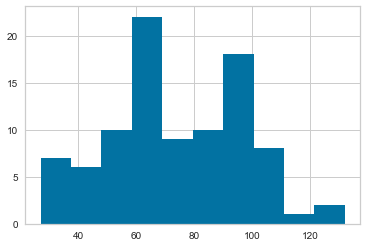

In [36]:
grass['Attack'].hist(bins=10)
grass['Attack'].describe()

count     56.000000
mean      91.785714
std       34.805284
min       10.000000
25%       63.000000
50%       92.500000
75%      116.250000
max      165.000000
Name: Attack, dtype: float64

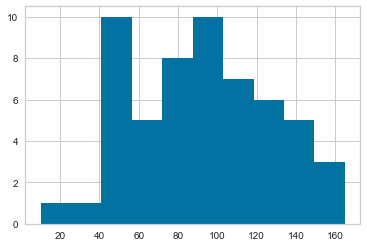

In [37]:
rock['Attack'].hist(bins=10)
rock['Attack'].describe()

Conclusion: Rock pokemon have stronger attacks than grass pokemon !!

(10 points) Professor Oak reveals to you that he has built a backdoor into every Pokedex in the world and that he is secretly dumping the memory of all devices to his servers. He expects to have the records of 1 billion combats soon, and one machine won’t be enough to handle all this data, so he wants you to use Spark. Your task: Solve problem 2iv above (“list the names of the 10 Pokémon with the largest number of victories”) with a Spark implementation in Python. The output should be a Python list with 10 names sorted in descending order of number of victories. Note: You don’t need to run the Spark code -- just list it! You should assume that you have two DataFrames (already loaded) called pokemon and combats, with the same schema as the small CSV files you’ve been working with above.

In [38]:
# SKIPPY :D

Now that you know what your data looks like, you are ready to implement the prediction model for the Pokedex 2.0. The model should take as input the features of two Pokémon and generate a binary value to predict who will win.

(3 points) Generate the feature vectors and the labels to train your model.

In [39]:
pokemon.pop('A_D_ratio')

0      1.000000
1      0.984127
2      0.987952
3      0.813008
4      1.209302
         ...   
795    0.666667
796    1.454545
797    1.833333
798    2.666667
799    0.916667
Name: A_D_ratio, Length: 800, dtype: float64

In [40]:
print(pokemon.shape)
pokemon.head()

(800, 11)


,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [41]:
types = pokemon['Class 1'].unique()

In [42]:
for typ in types:
    pokemon[typ] = (pokemon['Class 1']==typ).astype(int) + (pokemon['Class 2']==typ).astype(int)

In [43]:
pokemon

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Fairy,Fighting,Psychic,Rock,Ghost,Ice,Dragon,Dark,Steel,Flying
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,0,0,0,0,0,0,0,0,0,0
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,0,0,0,0,0,0,0,0,0,0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,0,0,0,0,0,0,0,0,0,0
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,...,0,0,0,0,0,0,0,0,0,0
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,...,1,0,0,1,0,0,0,0,0,0
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,...,1,0,0,1,0,0,0,0,0,0
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,...,0,0,1,0,1,0,0,0,0,0
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,...,0,0,1,0,0,0,0,1,0,0


In [44]:
pokemon.pop('Class 1')
pokemon.pop('Class 2')

0      Poison
1      Poison
2      Poison
3      Poison
4         NaN
        ...  
795     Fairy
796     Fairy
797     Ghost
798      Dark
799     Water
Name: Class 2, Length: 800, dtype: object

In [45]:
names = pokemon['Name']

In [46]:
pokemon.pop('Name')

0           Bulbasaur
1             Ivysaur
2            Venusaur
3       Mega Venusaur
4          Charmander
            ...      
795           Diancie
796      Mega Diancie
797    Hoopa Confined
798     Hoopa Unbound
799         Volcanion
Name: Name, Length: 800, dtype: object

In [47]:
pokemon['Legendary'] = pokemon['Legendary'].astype(int)

In [48]:
# we'll just set the classes equal to integers, their value wont represent any magnitude, oh well.

In [49]:
combat.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [50]:
battle = combat.copy()
battle['P1'] = combat['First_pokemon']
battle['P2'] = combat['Second_pokemon']
battle['P1_win'] = (combat['Winner'] == combat['First_pokemon']).astype(int)
battle.pop('First_pokemon')
battle.pop('Second_pokemon')
battle.pop('Winner')
print(battle.shape)
battle.head(7)

(50000, 3)


,P1,P2,P1_win
0,266,298,0
1,702,701,0
2,191,668,0
3,237,683,0
4,151,231,1
5,657,752,1
6,192,134,0


In [51]:
pok1 = battle['P1'].values

In [52]:
pok1 = pokemon.iloc[pok1-1]
pok1.head()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Grass,Fire,...,Fairy,Fighting,Psychic,Rock,Ghost,Ice,Dragon,Dark,Steel,Flying
265,266,50,64,50,45,50,41,0,0,0,...,0,0,0,1,0,0,0,0,0,0
701,702,91,90,72,90,129,108,1,1,0,...,0,1,0,0,0,0,0,0,0,0
190,191,55,40,85,80,105,40,0,0,0,...,1,0,0,0,0,0,0,0,0,1
236,237,40,40,40,70,40,20,0,0,1,...,0,0,0,0,0,0,0,0,0,0
150,151,70,60,125,115,70,55,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [53]:
pok2 = battle['P2'].values
pok2 = pokemon.iloc[pok2-1]
pok2.head()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Grass,Fire,...,Fairy,Fighting,Psychic,Rock,Ghost,Ice,Dragon,Dark,Steel,Flying
297,298,70,70,40,60,40,60,0,1,0,...,0,0,0,0,0,0,0,1,0,0
700,701,91,129,90,72,90,108,1,0,0,...,0,1,0,1,0,0,0,0,0,0
667,668,75,75,75,125,95,40,0,0,0,...,0,0,1,0,0,0,0,0,0,0
682,683,77,120,90,60,90,48,0,0,0,...,0,0,0,0,0,0,1,0,0,0
230,231,20,10,230,10,230,5,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [54]:
pok1 = pok1.reset_index()
pok1.pop('index')
pok2 = pok2.reset_index()
pok2.pop('index')

0        297
1        700
2        667
3        682
4        230
        ... 
49995    125
49996    663
49997    367
49998     88
49999     72
Name: index, Length: 50000, dtype: int64

In [55]:
for column in pok1.columns:
    pok1['1: '+column] = pok1[column]
    pok1.pop(column)

In [56]:
for column in pok2.columns:
    pok2['2: '+column] = pok2[column]
    pok2.pop(column)

In [57]:
X = pd.concat([pok1,pok2], axis=1)

In [58]:
y = battle['P1_win']

In [59]:
X

,1: pid,1: HP,1: Attack,1: Defense,1: Sp. Atk,1: Sp. Def,1: Speed,1: Legendary,1: Grass,1: Fire,...,2: Fairy,2: Fighting,2: Psychic,2: Rock,2: Ghost,2: Ice,2: Dragon,2: Dark,2: Steel,2: Flying
0,266,50,64,50,45,50,41,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,702,91,90,72,90,129,108,1,1,0,...,0,1,0,1,0,0,0,0,0,0
2,191,55,40,85,80,105,40,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,237,40,40,40,70,40,20,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,151,70,60,125,115,70,55,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,707,100,120,100,150,120,90,1,0,1,...,0,0,0,0,0,0,0,0,0,0
49996,589,60,85,40,30,45,68,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,303,60,50,100,85,70,65,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,109,40,30,50,55,55,100,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
y

0        0
1        0
2        0
3        0
4        1
        ..
49995    1
49996    1
49997    0
49998    1
49999    1
Name: P1_win, Length: 50000, dtype: int32

(5 points) How does your model handle categorical features and Pokémon with multiple classes?

In [61]:
# Just as categroical strings?

(10 points) Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (n_estimators, try values 10, 25, 50, 100) and the maximum tree depth (max_depth, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.

In [62]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1, random_state=2)

In [63]:
random_forest = RandomForestClassifier()
random_forest.fit(X_tr, y_tr)
y_predict = random_forest.predict(X_val)
accuracy = accuracy_score(y_val, y_predict)
print("Random Forest:  "+str(np.round(accuracy*100,4))+' %  accuracy')

C:\Users\NathanSennesael\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest:  92.28 %  accuracy


(5 points) Summarize and describe the results you obtain when training on 90% and testing on 10% of the data. What is the best combination of the two hyperparameters (number of estimators and maximum tree depth)?

In [64]:
max_depths = [2, 4, 10]
n_estimators = [10, 25, 50, 100]


for n_est in n_estimators:
    for max_depth in max_depths:
        random_forest = RandomForestClassifier(n_estimators=n_est, max_depth=max_depth)
        random_forest.fit(X_tr, y_tr)
        y_predict = random_forest.predict(X_val)
        accuracy = accuracy_score(y_val, y_predict)
        print('max_depth: '+str(max_depth))
        print('n_estimators: '+str(n_est))
        print("Random Forest:  "+str(np.round(accuracy*100,4))+' %  accuracy')

max_depth: 2
n_estimators: 10
Random Forest:  75.82 %  accuracy
max_depth: 4
n_estimators: 10
Random Forest:  78.68 %  accuracy
max_depth: 10
n_estimators: 10
Random Forest:  90.44 %  accuracy
max_depth: 2
n_estimators: 25
Random Forest:  77.58 %  accuracy
max_depth: 4
n_estimators: 25
Random Forest:  82.0 %  accuracy
max_depth: 10
n_estimators: 25
Random Forest:  90.44 %  accuracy
max_depth: 2
n_estimators: 50
Random Forest:  79.1 %  accuracy
max_depth: 4
n_estimators: 50
Random Forest:  82.94 %  accuracy
max_depth: 10
n_estimators: 50
Random Forest:  91.28 %  accuracy
max_depth: 2
n_estimators: 100
Random Forest:  77.7 %  accuracy
max_depth: 4
n_estimators: 100
Random Forest:  82.74 %  accuracy
max_depth: 10
n_estimators: 100
Random Forest:  91.38 %  accuracy


In [65]:
# more complex model gives better results

(5 points) Could the above training/testing setup potentially lead to wrong conclusions regarding the best hyperparameter setting? If so, describe why, and how you would address the problem. (Hint: think about how you’re making use of the data during training and testing).

In [66]:
# Changing the seed does change the results so we can be pretty confident about our results.
#  We could use cross-validation instead

(7 points) Implement your solution to the problem you’ve identified in the previous subquestion (5), and show and describe your results.

In [67]:
# not sure

(5 points) Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.

Feature ranking:
1. feature 6 (0.178185)1: Speed
2. feature 32 (0.171021)2: Speed
3. feature 2 (0.043053)1: Attack
4. feature 28 (0.042515)2: Attack
5. feature 4 (0.037802)1: Sp. Atk
6. feature 30 (0.036707)2: Sp. Atk
7. feature 31 (0.029426)2: Sp. Def
8. feature 5 (0.029043)1: Sp. Def
9. feature 1 (0.027907)1: HP
10. feature 27 (0.027157)2: HP
11. feature 3 (0.025682)1: Defense
12. feature 29 (0.025407)2: Defense
13. feature 26 (0.024584)2: pid
14. feature 0 (0.024120)1: pid
15. feature 25 (0.014365)1: Flying
16. feature 7 (0.014074)1: Legendary
17. feature 33 (0.014032)2: Legendary
18. feature 51 (0.012128)2: Flying
19. feature 38 (0.009052)2: Normal
20. feature 36 (0.008987)2: Water
21. feature 12 (0.008784)1: Normal
22. feature 46 (0.008687)2: Ghost
23. feature 10 (0.008607)1: Water
24. feature 41 (0.007828)2: Ground
25. feature 20 (0.007744)1: Ghost
26. feature 44 (0.007654)2: Psychic
27. feature 8 (0.007436)1: Grass
28. feature 34 (0.007385)2: Grass
29. feature 18 (0.007362)1: Ps

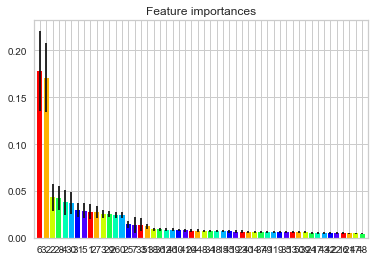

In [69]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_tr, y_tr)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_tr.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])+X_tr.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_tr.shape[1]), importances[indices], color=[(1, 0, 0, 1),(1, 0.7, 0, 1),(0.8, 1, 0, 1),(0.1, 1, 0.3, 1),(0, 1, 0.7, 1),(0, 0.7, 1, 1),(0, 0, 1, 1),(0.3, 0, 1, 1)], yerr=std[indices], align="center")
plt.xticks(range(X_tr.shape[1]), indices)
plt.xlim([-1, X_tr.shape[1]])
plt.show()

(5 points) Compute the winning ratio (number of wins divided by number of battles) for all Pokémon. Show the 10 Pokémon with the highest ratio and describe what they have in common with respect to their features. Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.

In [70]:
combat['Winner']

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151
